<a href="https://colab.research.google.com/github/parhamidi/crack-detection-opencv/blob/parhamidi-testing-1/Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This a code is to prepare the data to be fed to Pytorch for transfer learning

## Loading the data

In [2]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow    
import matplotlib.pylab as plt

plt.rcParams['figure.figsize'] = (10,10)

In [3]:
## A function that uses plot to show original and output image
def plot_result(original,processed):
    plt.subplot(121),plt.imshow(original)
    plt.title('Original'),plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(processed,cmap='gray')
    plt.title("Output"),plt.xticks([]), plt.yticks([])
    plt.show()

In [4]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/data/Input-Set/Parking Lot/'
# A list with the data 
data_list = []
for i in range(1, 12):
  data_list.append(cv2.imread(path+'Lot'+str(i)+'.tif', cv2.IMREAD_COLOR))

In [6]:
# Choosing a sample image (int)
sample_number = 0
sample_im = data_list[sample_number]
sample_labelled = cv2.imread('/content/drive/MyDrive/data/Parham_labelled data/Parking Lot_labelled/Lot1m.png', cv2.IMREAD_GRAYSCALE)

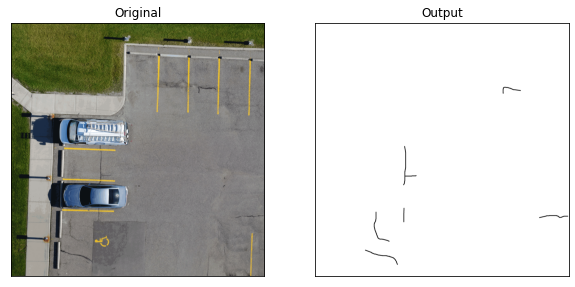

Current image size of original is (3724, 3724, 3) and output is (3724, 3724)


In [7]:
#Coverting colors from BGR to RGB (to see the right image)
# Can use $sample_im = sample_im[:,:,::-1]$ too
#sample_im = cv2.cvtColor(sample_im, cv2.COLOR_BGR2RGB)

# Comaring the label and the original data
plot_result(sample_im[:,:,::-1],sample_labelled)
print(f"Current image size of original is {sample_im.shape} and output is {sample_labelled.shape}")

In [8]:
# can use sample_labelled[:,:,np.newaxis] to add new axis
# print(f"Current image size of original is {sample_im.shape} and output is {sample_labelled.shape}")

## Turning the data into overlapping tiles

In [9]:
# A function to grid/tile the pictyre
def add_grid(img, dx, dy=None):

  im = np.copy(img)
  if dy is None: dy = dx

  grid_color = [300,0,0]

  im[:,::dy,:] = grid_color
  im[::dx,:,:] = grid_color

  plt.imshow(im)
  plt.axis('off')
  plt.show()

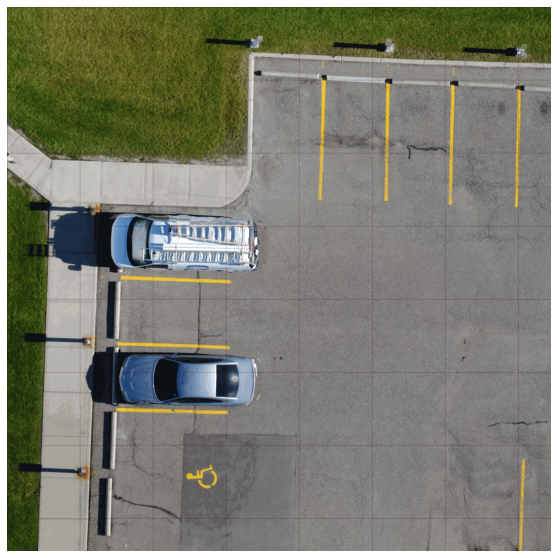

In [10]:
# Setting squares of size 500 
dx = 500
add_grid(sample_im[:,:,::-1], dx)
#add_grid(sample_labelled[:,:,np.newaxis], dx)

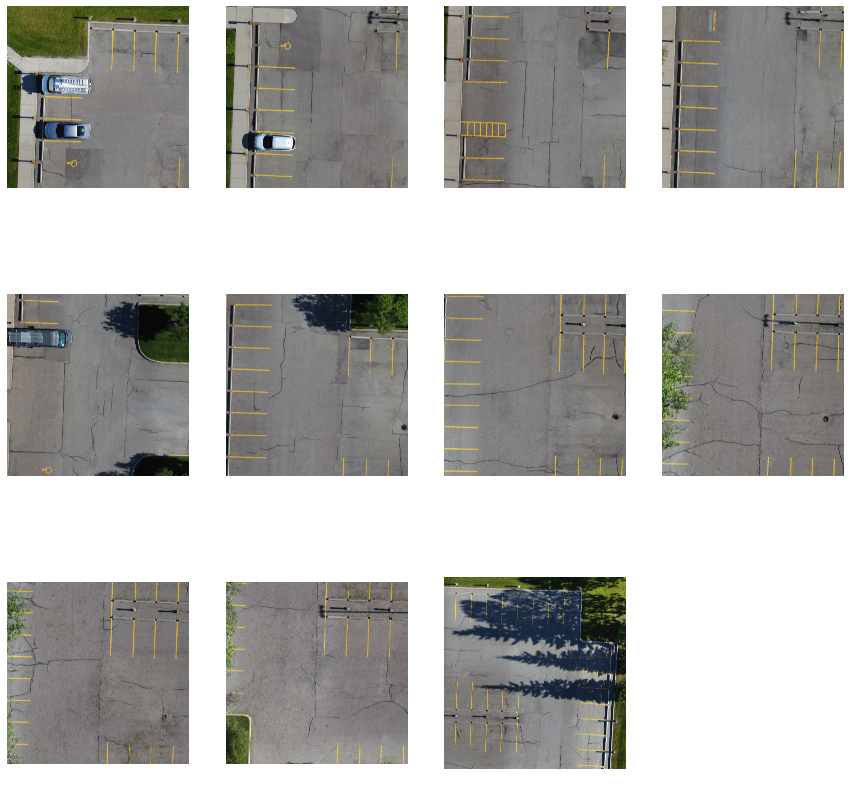

In [13]:
# Lokking at all data
fig, ax = plt.subplots(3, 4, figsize=(15,15))
for i in range(3):
  for j in range(4):
    if 4*i+j < 11:
      ax[i][j].imshow( data_list[4*i+j][:,:,::-1])
    ax[i][j].axis('off')

In [14]:
# concatenate sample and sample_lablled
p1 = np.concatenate((sample_im[:,:,::-1], sample_labelled[:,:,np.newaxis]), axis=2)
print(p1.dtype)

uint8


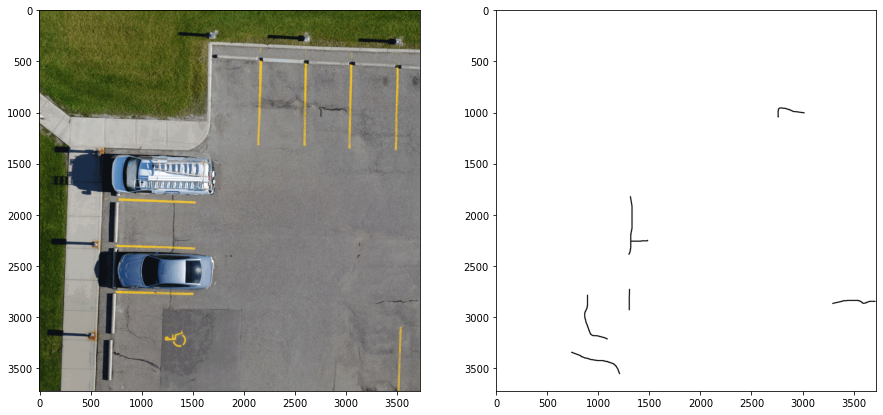

In [15]:
# Now sample_labelled has the same dimension (done while concatenating), and can use p1 from now on (see below for pytorch):
fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(p1[:,:,:3])
ax[1].imshow(p1[:,:,3], cmap='gray')
fig.show()

## Testing with PyTorch

In [16]:
import torch
import torch.nn.functional as F

The shape of the torch sample is torch.Size([1, 4, 3724, 3724]), with the type torch.uint8

 The (new) shape is torch.Size([3, 3724, 3724])


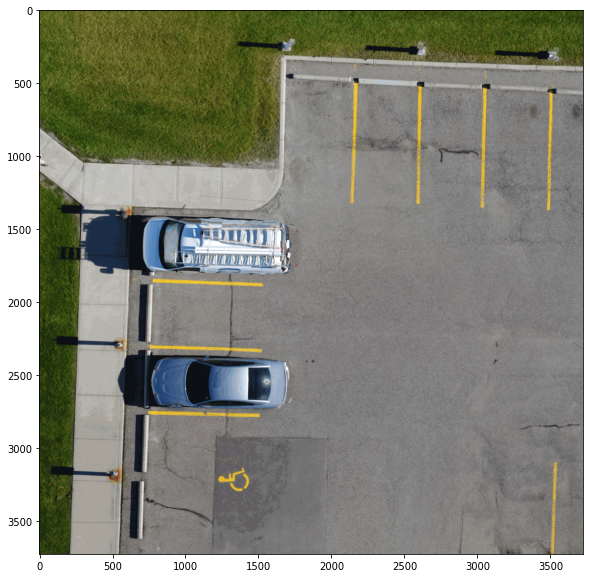

In [17]:
torch_sample = torch.from_numpy(p1).permute(2,0,1).unsqueeze(0)
print(f"The shape of the torch sample is {torch_sample.shape}, with the type {torch_sample.dtype}")
# To see the old dimensions:
plt.imshow(torch_sample[0,:3,:,:].permute(1,2,0))
print(f"\n The (new) shape is {torch_sample[0,:3,:,:].shape}")

In [18]:
"""print(torch_sample.shape, '\n',
      torch_sample.stride(), '\n',
      torch_sample.contiguous().stride())"""

"print(torch_sample.shape, '\n',\n      torch_sample.stride(), '\n',\n      torch_sample.contiguous().stride())"

torch.Size([1, 4, 7, 7, 700, 700])


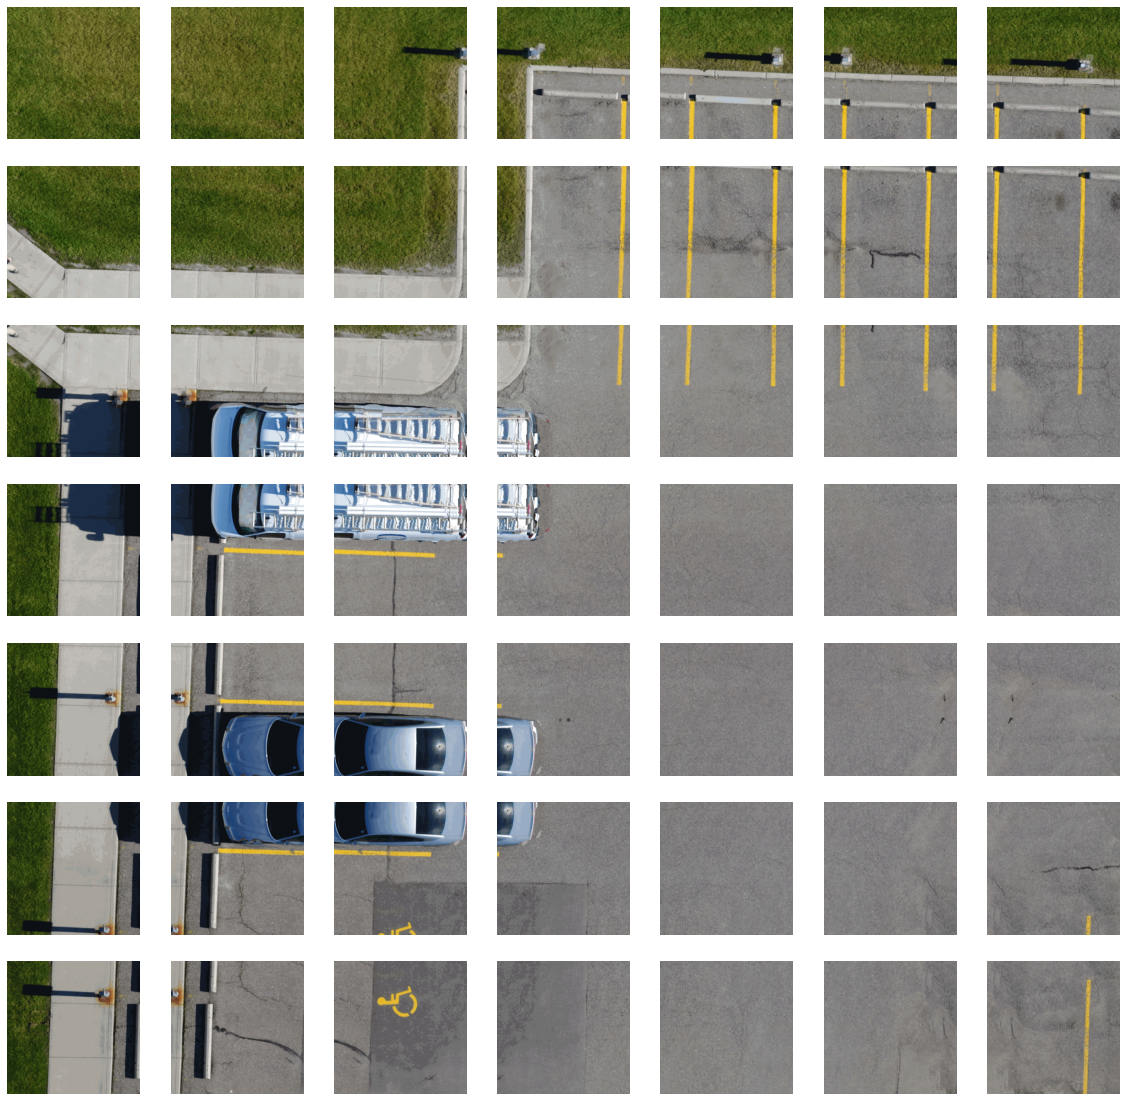

In [20]:
k = 700
s = 500
p = torch_sample.unfold(2, k, s).unfold(3, k, s)
print(p.size())

n = p.size(2)
fig, ax = plt.subplots(n, n, figsize=(20, 20))
for i in range(n):
  for j in range(n):
    ax[i][j].imshow(p[0,:3, i,j, :,:].permute(1,2,0))
    ax[i][j].axis('off')

22% of patches have cracks


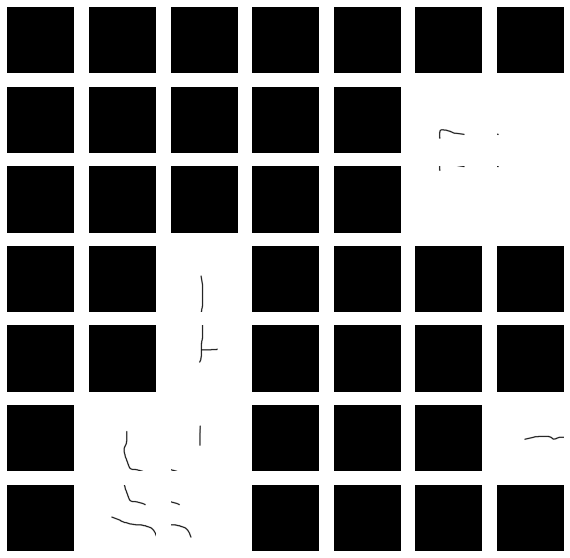

In [21]:
fig, ax = plt.subplots(n, n, figsize=(10, 10))
c = 0
for i in range(n):
  for j in range(n):
    ax[i][j].imshow(p[0,3, i,j, :,:], cmap='gray')
    ax[i][j].axis('off')
    if p[0,3, i,j, :,:].min() == 255:
      c += 1
# Black square means no crack in this patch
print(f'{100-(c/(n*n)*100):.0f}% of patches have cracks')

In [23]:
{img.shape for img in data_list}

{(3724, 3724, 3), (5501, 5233, 3)}

In [24]:
# The last file is bigger